2026-01-24 06:41:43.080385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769236903.444698      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769236903.567136      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769236904.642891      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769236904.642938      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769236904.642941      24 computation_placer.cc:177] computation placer alr

🚀 Device: cuda | GPUs Available: 2
✅ Samples: 121 | Train: 96 | Val: 25


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


🚀 Starting SOTA Training...
Epoch 1 | Train Acc: 0.5521 | Val Acc: 0.5600 (Saved Best) 💾
Epoch 2 | Train Acc: 0.7292 | Val Acc: 0.7600 (Saved Best) 💾
Epoch 3 | Train Acc: 0.7188 | Val Acc: 0.7600
Epoch 4 | Train Acc: 0.8646 | Val Acc: 0.7600
Epoch 5 | Train Acc: 0.9167 | Val Acc: 0.7200
Epoch 6 | Train Acc: 0.9583 | Val Acc: 0.7600
Epoch 7 | Train Acc: 0.9792 | Val Acc: 0.7600
Epoch 8 | Train Acc: 0.9792 | Val Acc: 0.8000 (Saved Best) 💾
Epoch 9 | Train Acc: 0.9583 | Val Acc: 0.8000
Epoch 10 | Train Acc: 0.9479 | Val Acc: 0.8000
Epoch 11 | Train Acc: 1.0000 | Val Acc: 0.8000
Epoch 12 | Train Acc: 1.0000 | Val Acc: 0.8000
Epoch 13 | Train Acc: 0.9792 | Val Acc: 0.7200
Epoch 14 | Train Acc: 0.9688 | Val Acc: 0.7200
Epoch 15 | Train Acc: 0.9896 | Val Acc: 0.7200
Epoch 16 | Train Acc: 1.0000 | Val Acc: 0.7200
Epoch 17 | Train Acc: 1.0000 | Val Acc: 0.7200
Epoch 18 | Train Acc: 1.0000 | Val Acc: 0.7200
Epoch 19 | Train Acc: 0.9896 | Val Acc: 0.7200
Epoch 20 | Train Acc: 1.0000 | Val Acc: 0.

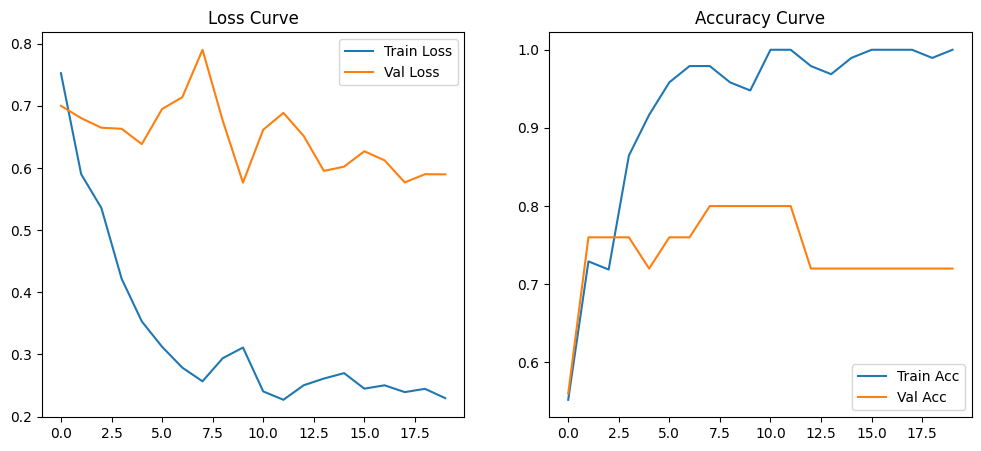

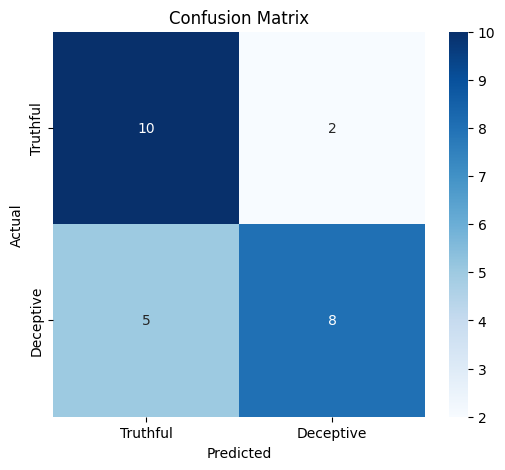

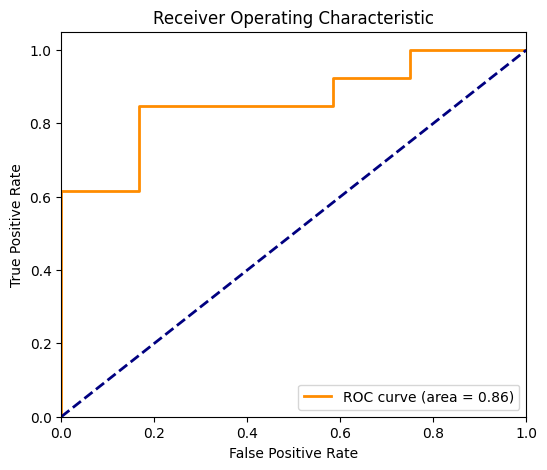


--- Final Report ---
              precision    recall  f1-score   support

    Truthful       0.67      0.83      0.74        12
   Deceptive       0.80      0.62      0.70        13

    accuracy                           0.72        25
   macro avg       0.73      0.72      0.72        25
weighted avg       0.74      0.72      0.72        25



In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import DistilBertModel, DistilBertTokenizer, ViTModel, ViTImageProcessor
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# ==========================================
# 1. CONFIGURATION (TUNED FOR PERFORMANCE)
# ==========================================
DATASET_PATH = '/kaggle/input/truthfull/Real-life_Deception_Detection_2016'
BATCH_SIZE = 16          # Smaller batch size for better generalization on small data
EPOCHS = 20              # Increased epochs for scheduler convergence
LR_BASE = 1e-4           # Base learning rate
WEIGHT_DECAY = 1e-3      # Regularization
MAX_FRAMES = 10          # Increased frames to capture more temporal context
MAX_TEXT_LEN = 128
NUM_WORKERS = 4
DROPOUT_RATE = 0.5       # High dropout to prevent overfitting

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()
print(f"🚀 Device: {device} | GPUs Available: {num_gpus}")

# ==========================================
# 2. ADVANCED DATASET (With Strong Augmentation)
# ==========================================
class DeceptionDataset(Dataset):
    def __init__(self, samples, mode='train', max_frames=8, max_length=128):
        self.samples = samples
        self.mode = mode
        self.max_frames = max_frames
        self.max_length = max_length
        
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

        # Advanced Augmentation: Jitter, Flip, Rotation
        if self.mode == 'train':
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor() 
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor()
            ])

    def __len__(self):
        return len(self.samples)

    def load_video_frames(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total_frames <= 0:
            return [np.zeros((224, 224, 3), dtype=np.uint8)] * self.max_frames
        
        indices = np.linspace(0, total_frames - 1, self.max_frames, dtype=int)
        for i in range(total_frames):
            ret, frame = cap.read()
            if not ret: break
            if i in indices:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                if self.transform:
                    frame_t = self.transform(frame)
                    frame = frame_t.permute(1, 2, 0).numpy() * 255 
                frames.append(frame.astype(np.uint8))
        cap.release()
        
        while len(frames) < self.max_frames:
            frames.append(np.zeros((224, 224, 3), dtype=np.uint8))
        return frames[:self.max_frames]

    def load_text(self, path):
        try:
            with open(path, 'r', encoding='utf-8', errors='ignore') as f:
                return f.read().strip()
        except: return ""

    def __getitem__(self, idx):
        vid_path, txt_path, label = self.samples[idx]
        
        text = self.load_text(txt_path)
        text_inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        raw_frames = self.load_video_frames(vid_path)
        video_inputs = self.image_processor(images=raw_frames, return_tensors="pt")

        return {
            'input_ids': text_inputs['input_ids'].squeeze(0),
            'attention_mask': text_inputs['attention_mask'].squeeze(0),
            'pixel_values': video_inputs['pixel_values'],
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ==========================================
# 3. SOTA MODEL: Cross-Attention Fusion
# ==========================================
class CrossAttentionFusion(nn.Module):
    def __init__(self, dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 2, dim)
        )
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, query, key_value):
        # query: Text features, key_value: Video features (or vice versa)
        attn_output, _ = self.multihead_attn(query, key_value, key_value)
        x = self.norm(query + attn_output)
        ffn_output = self.ffn(x)
        return self.norm2(x + ffn_output)

class SOTADeceptionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(SOTADeceptionModel, self).__init__()
        
        # 1. Encoders
        self.text_encoder = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.video_encoder = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        
        # Unfreeze last layer of encoders for fine-tuning
        for param in self.text_encoder.parameters(): param.requires_grad = False
        for param in self.text_encoder.transformer.layer[-1].parameters(): param.requires_grad = True
        
        for param in self.video_encoder.parameters(): param.requires_grad = False
        for param in self.video_encoder.encoder.layer[-1].parameters(): param.requires_grad = True

        # 2. Adapters
        self.text_proj = nn.Linear(768, 512)
        self.video_proj = nn.Linear(768, 512)
        
        # 3. Temporal Modeling for Video (LSTM)
        self.video_lstm = nn.LSTM(input_size=512, hidden_size=512, batch_first=True, bidirectional=False)
        
        # 4. Cross Attention (Text attends to Video)
        self.cross_attn = CrossAttentionFusion(dim=512, num_heads=4, dropout=0.3)
        
        # 5. Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, pixel_values):
        # --- Text Features ---
        text_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        # Sequence of text tokens: (Batch, Seq_Len, 768)
        text_seq = self.text_proj(text_out.last_hidden_state) 
        
        # --- Video Features ---
        b, f, c, h, w = pixel_values.shape
        pixel_values_flat = pixel_values.view(b * f, c, h, w)
        video_out = self.video_encoder(pixel_values=pixel_values_flat)
        video_feat = video_out.last_hidden_state[:, 0, :] # CLS token per frame
        
        # Reshape to sequence: (Batch, Frames, 768)
        video_seq = video_feat.view(b, f, -1)
        video_seq = self.video_proj(video_seq) # (Batch, Frames, 512)
        
        # Apply LSTM to get temporal context
        video_seq, _ = self.video_lstm(video_seq) # (Batch, Frames, 512)

        # --- Cross Attention Fusion ---
        # We treat Video as the "Memory" (Key/Value) and Text as the "Query"
        # We want to find which video frames match the text context
        fused_seq = self.cross_attn(query=text_seq, key_value=video_seq)
        
        # Pooling: Use the CLS token from the text (now enriched with video info)
        # fused_seq shape: (Batch, Seq_Len, 512)
        cls_token = fused_seq[:, 0, :] 
        
        logits = self.classifier(cls_token)
        return logits

# ==========================================
# 4. HELPER FUNCTIONS
# ==========================================
def get_all_samples(root_dir):
    samples = []
    categories = {'Deceptive': 1, 'Truthful': 0}
    if not os.path.exists(root_dir): return []

    for category, label in categories.items():
        clip_path = os.path.join(root_dir, 'Clips', category)
        trans_path = os.path.join(root_dir, 'Transcription', category)
        if not os.path.exists(clip_path): continue
        
        for video_file in os.listdir(clip_path):
            if video_file.endswith('.mp4'):
                base_name = os.path.splitext(video_file)[0]
                txt_file = base_name + '.txt'
                txt_full_path = os.path.join(trans_path, txt_file)
                vid_full_path = os.path.join(clip_path, video_file)
                if os.path.exists(txt_full_path):
                    samples.append((vid_full_path, txt_full_path, label))
    return samples

# ==========================================
# 5. MAIN PIPELINE
# ==========================================
def run_sota_pipeline():
    # 1. Data Prep
    all_samples = get_all_samples(DATASET_PATH)
    # Stratified Split
    train_samples, val_samples = train_test_split(all_samples, test_size=0.2, random_state=42, stratify=[s[2] for s in all_samples])
    
    print(f"✅ Samples: {len(all_samples)} | Train: {len(train_samples)} | Val: {len(val_samples)}")
    
    train_ds = DeceptionDataset(train_samples, mode='train', max_frames=MAX_FRAMES)
    val_ds = DeceptionDataset(val_samples, mode='val', max_frames=MAX_FRAMES)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    
    # 2. Model Init
    model = SOTADeceptionModel()
    if num_gpus > 1:
        model = nn.DataParallel(model)
    model = model.to(device)
    
    # 3. Optimization Setup
    # Label Smoothing helps with overfitting
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR_BASE, weight_decay=WEIGHT_DECAY)
    
    # Cosine Scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
    
    # 4. Training
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    best_val_acc = 0.0
    
    print("\n🚀 Starting SOTA Training...")
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, pixel_values)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient Clipping (Important for LSTMs/Transformers)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        y_true, y_pred, y_probs = [], [], []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                pixel_values = batch['pixel_values'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask, pixel_values)
                loss = criterion(outputs, labels)
                
                # Get probabilities for ROC
                probs = F.softmax(outputs, dim=1)[:, 1]
                
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
                y_probs.extend(probs.cpu().numpy())
        
        val_loss = val_running_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Step Scheduler
        scheduler.step()
        
        # Save Best Model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_sota_model.pth")
            print(f"Epoch {epoch+1} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f} (Saved Best) 💾")
        else:
            print(f"Epoch {epoch+1} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}")

    # ==========================================
    # 6. VISUALIZATION & PLOTTING
    # ==========================================
    print("\n--- Generating Plots ---")
    
    # 1. Loss & Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Curve')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.savefig('training_curves.png')
    plt.show()
    
    # 2. Confusion Matrix 
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Truthful', 'Deceptive'], yticklabels=['Truthful', 'Deceptive'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # 3. ROC Curve 
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()

    print("\n--- Final Report ---")
    print(classification_report(y_true, y_pred, target_names=['Truthful', 'Deceptive']))

if __name__ == "__main__":
    run_sota_pipeline()